In [1]:
# install packages
! pip install pandas==1.1.5
! pip install xgboost==1.4.2
! pip install numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires pandas>=1.3, but you have pandas 1.1.5 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 MB 5.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/col

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, average_precision_score

import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = os.getcwd()

# Check if running in Colab
try:
  from google.colab import drive
  IN_COLAB=True
  print("Running in Colab")
  # Mount Google Drive 
  drive.mount('/content/drive')
  # Change directory
  path = "/content/drive/My \Drive/BitterMatch"
  %cd /content/drive/My \Drive/BitterMatch
except:
  IN_COLAB=False
  print("Running locally")

Running in Colab
Mounted at /content/drive
/content/drive/My Drive/BitterMatch


In [4]:
from similarity import *
from preprocessing import *

## 1. Load data and pre-process to obtain inputs


To train the model the following input is required:
* $A \in \mathbb{R}^{L \times R}$ - An association matrix between $L$ ligands and $R$ receptors
* $X^{\text{Rec}}$ - A matrix of receptor features (each row corresponding to a receptor)
* $X^{\text{Lig}}$ - A matrix of ligand features (each row corresponding to a ligand)
* $S^{\text{Rec}}_1, \dots, S^{\text{Rec}}_k$ - Precomputed similarity matrices between receptors 
* $S^{\text{Lig}}_1, \dots, S^{\text{Lig}}_m$ - Precomputed similarity matrices between ligands 


Here we provide helper functions to obtain these inputs from the formats listed in the paper.
If the inputs are obtained from a different source the first section should be skipped or replaced.

Load and prepare $A, X^{\text{Rec}}, X^{\text{Lig}}$

In [5]:
A = load_A('Data/bitterdb_associations.csv')

# remove orphan receptors from association matrix
orphan_receptors = A.columns[np.sum(A, axis=0)==0]
A = A[A.columns[~np.isin(A.columns, orphan_receptors)]]

In [6]:
X_Rec = load_X_Rec('Data/receptor_features.csv')

# remove orphan receptors from receptor features matrix
X_Rec = X_Rec[~np.isin(X_Rec.column_label, orphan_receptors)]

In [7]:
X_Lig = load_X_Lig('Data/ligand_features.csv')

Load and prepare $S^{\text{Rec}}_1, \dots, S^{\text{Rec}}_4$

In [8]:
Rec_sim = read_receptor_similarity('Data/Columns_similarity_matrix.csv')
Rec_ident = read_receptor_similarity('Data/Columns_identity_matrix.csv')
Rec_sites_sim = read_receptor_similarity('Data/Col_Similarity_Bindingsite.csv')
Rec_sites_ident = read_receptor_similarity('Data/Col_Identity_Bindingsites.csv')

Load and prepare $S^{\text{Lig}}_1, S^{\text{Lig}}_2$

In [9]:
Lig_linear_sim = read_ligand_similarity('Data/Ligand_Linear_Similarity.csv') 
Lig_mol2d_sim = read_ligand_similarity('Data/Ligand_mol2D_Similarity.csv')

## 2. Prepare feature matrix

In [10]:
# create data frame of all pairs of ligand-receptor
pairs = pd.melt(A.assign(ligand=A.index), id_vars='ligand', var_name='receptor', value_name='association')
# shuffle
pairs = pairs.sample(frac=1).reset_index(drop=True)
pairs = pairs[~np.isnan(pairs.association)]

### 2.1 Determine train-test split and mask test associations from $A$

In [11]:
def train_test_split(pairs_df, p=0.8):
    # split to train and test such that train contains p of each column's ones and p of each column's zeros
    pairs_df['num'] = pairs_df.groupby(['receptor', 'association']).cumcount() + 1
    pairs_df = pairs_df.merge(pairs_df.groupby(['receptor', 'association'])['num'].max(), how='outer', on=['receptor', 'association'])

    # if there are enough ones choose first 1-p ligands, else choose at random
    pairs_df['test'] = np.where(pairs_df.num_y > 1/(1-p),
                             (pairs_df.num_x/pairs_df.num_y) <= 1-p,
                             np.random.random(len(pairs_df)) <= 1-p)
    pairs_df = pairs_df.drop(['num_x', 'num_y'], axis=1)
    
    return pairs_df

In [12]:
pairs = train_test_split(pairs)

In [13]:
# mask test values in association matrix
masked_A = A.mask(pairs.pivot(index='ligand', columns='receptor', values='test').astype('bool'))

In [14]:
test_ligands = np.unique(pairs.ligand[pairs.test==True])

### 2.2 Add chemical properties of ligands and receptors

In [15]:
# cross join ligand and receptor data
features_df = pd.merge(X_Lig.rename(columns=lambda r: 'Lig_%s' % r).assign(key_=1),
                       X_Rec.rename(columns=lambda c: 'Rec_%s' % c).assign(key_=1),
                       on='key_').drop('key_', 1)
features_df = features_df.rename(columns={'Lig_cid': 'ligand', 'Rec_column_label': 'receptor'})

# add a feature indicating whether the receptor is human
features_df['is_human_receptor'] = features_df.receptor<2000

# add association (ground truth) and train/test split
features_df = features_df.merge(pairs, how='outer', on=['ligand', 'receptor'])

# shuffle
features_df = features_df.sample(frac=1)

### 2.3 Collaborative similarities

In [16]:
Lig_collab_sim = collaborative_similarity(masked_A, 'Ligand')
Rec_collab_sim = collaborative_similarity(masked_A, 'Receptor')

#### 2.3.1 Extract similarity based metrics
$W_{l1}$ -  average similarity of the ligand $l$ to ligands $l'$ that associate with a receptor $r$ <br />
$W_{l0}$ - average similarity of the ligand $l$ to ligands $l'$ that do not associate with a receptor $r$  <br /> 
$M_{l1}$  - similarity between the ligand $l$  and the most similar ligand that associates with a receptor  r <br />
$M_{l0}$  - similarity between the ligand $l$  and the most similar ligand that does not associate with a receptor  r <br />

$W_{r1}$ - average similarity of the receptor $r$ to receptors $r'$ that  associate with the ligand $l$ <br />
$W_{r0}$ - average similarity of the receptor $r$ to receptors $r'$ that  do not associate with the ligand $l$ <br />
$M_{r1}$ - similarity between the receptor $r$  and the most similar receptor that associates with a ligand $l$  <br />
$M_{r0}$ - similarity between the receptor $r$  and the most similar receptor that does not associate with a ligand $l$ <br />

In [17]:
sim_metrics_dict = {'Lig_collab_sim':       (Lig_collab_sim,   0),
                    'Lig_linear_sim':       (Lig_linear_sim,   0),
                    'Lig_mol2d_sim':        (Lig_mol2d_sim,    0),
                    'Rec_collab_sim':       (Rec_collab_sim,   1),
                    'Rec_sim':              (Rec_sim,          1),
                    'Rec_sim_sites':        (Rec_sites_sim,    1),
                    'Rec_ident':            (Rec_ident,        1),
                    'Rec_ident_sites':      (Rec_sites_ident,  1)}

In [18]:
# add similarity based features to the features data frame
for prefix, (sim_df, axis) in sim_metrics_dict.items():
    sim_metrics_df = sim_metrics(sim_df, masked_A, axis).rename(columns=lambda receptor: '%s_%s' % (prefix, receptor))
    features_df = features_df.merge(sim_metrics_df, how='outer', on=['ligand', 'receptor'])

### 2.4 Create $X^{\text{Tr}}, X^{\text{Te}}, Y^{\text{Tr}}, Y^{\text{Te}}$ matrices  

In [19]:
X_train = features_df[(features_df.test == False) & (features_df.association.isna() == False)].drop(['ligand', 'receptor', 'association', 'test'], axis=1)

results_df = features_df[(features_df.test == True) & (features_df.association.isna() == False)]
X_test = results_df.drop(['ligand', 'receptor', 'association', 'test'], axis=1)
results_df = results_df[['ligand', 'receptor', 'association']]

Y_train = features_df[(features_df.test == False) & (features_df.association.isna() == False)].association.values
Y_test = features_df[(features_df.test == True) & (features_df.association.isna() == False)].association.values

## 3. Models

### 3.1 BitterMatch models

In [20]:
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic',  booster = 'gbtree',  n_jobs = -1, seed = 1,  subsample =  0.7, scale_pos_weight = 1,  min_child_weight = 0.45, max_depth =  4, learning_rate = 1e-3, gamma =  2.0, colsample_bytree = 0.3, colsample_bylevel = 1.0, n_estimators = 1000, silent = None, verbosity = 0)

In [21]:
# Full model (model no. 4)
full_model = xgb_clf.fit(X_train, Y_train)
Y_pred = full_model.predict_proba(X_test)

In [22]:
similarity_metrics = [name for name in list(features_df.columns) if ("_W0" in name) or ("_W1" in name) or ("_M0" in name) or ("_M1" in name)]

In [23]:
# Model with only chemical properties (model no. 1)
no_sim_X_train = X_train.drop(similarity_metrics, axis='columns', inplace=False)
no_sim_X_test = X_test.drop(similarity_metrics, axis='columns', inplace=False)

no_sim_model = xgb_clf.fit(no_sim_X_train, Y_train)
no_sim_Y_pred = no_sim_model.predict_proba(no_sim_X_test)

In [24]:
# Model with precomputed properties and collaborative similarities (model no. 2)
precomputed_similarities = [name for name in similarity_metrics if "collab_" not in name]

no_precomputed_X_train = X_train.drop(precomputed_similarities, axis='columns', inplace=False)
no_precomputed_X_test =  X_test.drop(precomputed_similarities, axis='columns', inplace=False)

no_precomputed_model = xgb_clf.fit(no_precomputed_X_train, Y_train)
no_precomputed_Y_pred = no_precomputed_model.predict_proba(no_precomputed_X_test)

In [25]:
# Model with chemical properties and precomputed similarities (model no. 3)
collaborative_similarities = [name for name in similarity_metrics if "collab_" in name]

non_collab_X_train = X_train.drop(collaborative_similarities, axis='columns', inplace=False)
non_collab_X_test = X_test.drop(collaborative_similarities, axis='columns', inplace=False)

no_collab_model = xgb_clf.fit(non_collab_X_train, Y_train)
no_collab_Y_pred = no_collab_model.predict_proba(non_collab_X_test)

In [26]:
# # Save a model (we recommend model no. 3)
# with open('Trained_Models/trained_model_no_3.pkl', 'wb') as f:
#     pickle.dump(no_collab_model, f)

### 3.2 Prior Model

In [27]:
prior = np.sum(masked_A, axis=0)/np.sum(~np.isnan(masked_A),axis=0)
results_df = results_df.join(prior.rename('prior'), on=["receptor"], how="left")

## 4. Results

In [28]:
Y_pred = Y_pred[:,1]
no_sim_Y_pred = no_sim_Y_pred[:,1]
no_collab_Y_pred = no_collab_Y_pred[:,1]
no_precomputed_Y_pred = no_precomputed_Y_pred[:,1]

prior_pred = results_df.prior

In [29]:
# Recall-precision curves
precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred)
no_sim_precision, no_sim_recall, no_sim_thresholds = precision_recall_curve(Y_test, no_sim_Y_pred)
no_collab_precision, no_collab_recall, no_collab_thresholds = precision_recall_curve(Y_test, no_collab_Y_pred)
no_precomputed_precision, no_precomputed_recall, no_precomputed_thresholds = precision_recall_curve(Y_test, no_precomputed_Y_pred)

prior_precision, prior_recall, prior_thresholds = precision_recall_curve(Y_test, prior_pred)


In [30]:
# Average precision
avg_precision = average_precision_score(Y_test, Y_pred)
no_sim_avg_precision = average_precision_score(Y_test, no_sim_Y_pred)
no_collab_avg_precision = average_precision_score(Y_test, no_collab_Y_pred)
no_precomputed_avg_precision = average_precision_score(Y_test, no_precomputed_Y_pred)

prior_avg_precision = average_precision_score(Y_test, prior_pred)

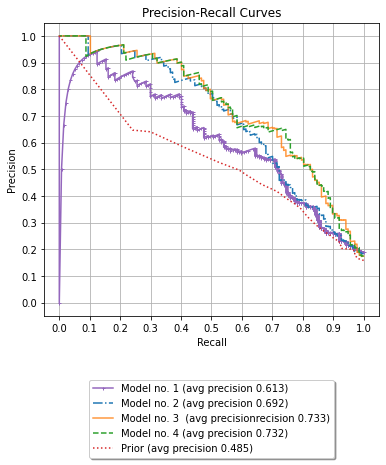

In [31]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

ax.plot(no_sim_recall, no_sim_precision, '-', marker='+',  label = 'Model no. 1 (avg precision {})'.format(np.round(no_sim_avg_precision,3)), color='C4', markersize=3)
ax.plot(no_precomputed_recall, no_precomputed_precision,  '-.', label = 'Model no. 2 (avg precision {})'.format(np.round(no_precomputed_avg_precision,3)), color='C0')
ax.plot(no_collab_recall, no_collab_precision,  label = 'Model no. 3  (avg precisionrecision {})'.format(np.round(no_collab_avg_precision,3)), color='C1', alpha=0.8)
ax.plot(recall, precision, label = 'Model no. 4 (avg precision {})'.format(np.round(avg_precision,3)), color='C2',linestyle= '--')

ax.plot(prior_recall, prior_precision, ':', label = 'Prior (avg precision {})'.format(np.round(prior_avg_precision,3)), color='C3')
ax.grid()

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=1)

plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1));

